<a href="https://colab.research.google.com/github/repairedserver/GoogleNet/blob/main/GoogleNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from torchsummary import summary

In [ ]:
def custom_imshow(img):
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(224),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


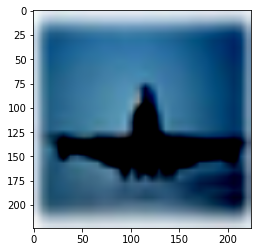

plane


In [ ]:
sample_num = 694

custom_imshow(trainset[sample_num][0])
print(classes[trainset[sample_num][1]])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3_red, ch3x3, ch5x5_red, ch5x5, pool):
        super(InceptionModule, self).__init__()
        
        self.conv1x1 = nn.Conv2d(in_channels, ch1x1, kernel_size=1)
        
        self.conv3x3 = nn.Sequential(
            BaseConv2d(in_channels, ch3x3_red, kernel_size=1),
            BaseConv2d(ch3x3_red, ch3x3, kernel_size=3, padding=1)
        )
        
        self.conv5x5 = nn.Sequential(
            BaseConv2d(in_channels, ch5x5_red, kernel_size=1),
            BaseConv2d(ch5x5_red, ch5x5, kernel_size=5, padding=2)
        )
        
        self.pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BaseConv2d(in_channels, pool, kernel_size=1)
        )
        
    def forward(self, x):
        x1 = self.conv1x1(x)
        x2 = self.conv3x3(x)
        x3 = self.conv5x5(x)
        x4 = self.pool(x)
        
        return torch.cat([x1, x2, x3, x4], 1)
    
class BaseConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BaseConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.ReLU = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.ReLU(self.conv(x))

In [ ]:
class GoogLeNet(torch.nn.Module):
    def __init__(self, in_channels, num_classes):
        super(GoogLeNet, self).__init__()

        self.training = True
        
        self.conv1 = nn.Sequential(
            BaseConv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.LocalResponseNorm(2)
        )

        self.conv2 = nn.Sequential(
            BaseConv2d(64, 64, kernel_size=1),
            BaseConv2d(64, 192, kernel_size=3, padding=1),
            nn.LocalResponseNorm(2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.inception_3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception_3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.maxpool_3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception_4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.aux1 = AuxModule(512, num_classes)


        self.inception_4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception_4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception_4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.aux2 = AuxModule(528, num_classes)

        self.inception_4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.maxpool_4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception_5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception_5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout2d(p=0.4)
        self.fc = nn.Linear(1024, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        x = self.inception_3a(x)
        x = self.inception_3b(x)
        x = self.maxpool_3(x)

        x = self.inception_4a(x)
        if self.training:
            out1 = self.aux1(x)

        x = self.inception_4b(x)
        x = self.inception_4c(x)
        x = self.inception_4d(x)
        if self.training:
            out2 = self.aux2(x)

        x = self.inception_4e(x)
        x = self.maxpool_4(x)

        x = self.inception_5a(x)
        x = self.inception_5b(x)

        x = self.avgpool(x)

        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)                
        if self.training:
            return [x, out1, out2]
        else:
            return x
    
    def set_train(self):
        self.training = True
        
    def set_eval(self):
        self.training = False
        

class AuxModule(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(AuxModule, self).__init__()

        self.avgpool = nn.AdaptiveAvgPool2d((4,4))
        self.conv1 = BaseConv2d(in_channels, 128, kernel_size=1)
        self.fc = nn.Sequential(
            nn.Linear(4*4*128, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.7),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.avgpool(x)
        x = self.conv1(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [ ]:
model = GoogLeNet(3,10).cuda()
summary(model, input_size=(3, 224, 224), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
              ReLU-2         [-1, 64, 112, 112]               0
        BaseConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
 LocalResponseNorm-5           [-1, 64, 56, 56]               0
            Conv2d-6           [-1, 64, 56, 56]           4,160
              ReLU-7           [-1, 64, 56, 56]               0
        BaseConv2d-8           [-1, 64, 56, 56]               0
            Conv2d-9          [-1, 192, 56, 56]         110,784
             ReLU-10          [-1, 192, 56, 56]               0
       BaseConv2d-11          [-1, 192, 56, 56]               0
LocalResponseNorm-12          [-1, 192, 56, 56]               0
        MaxPool2d-13          [-1, 192, 28, 28]               0
           Conv2d-14           [-1, 64,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [ ]:
lr = 1e-5
epochs = 100

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [12]:
for epoch in range(epochs):
    print("\nEpoch ", epoch)
    # train
    print("\nTrain:")
    model.train()
    model.set_train()
    train_loss = 0
    for i, (images, targets) in enumerate(train_loader): 
        images, targets = images.to(device), targets.to(device)
        
        pred0, pred1, pred2 = model(images)
        loss0 = F.cross_entropy(pred0, targets)    
        loss1 = F.cross_entropy(pred1, targets)    
        loss2 = F.cross_entropy(pred2, targets)    
        
        loss = loss0 + 0.3 * loss1 + 0.3  * loss2

        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if ((i+1) % (len(train_loader) // 30) == 1) or i+1 == len(train_loader):
            print('[%3d/%3d] | Loss: %.5f'%(i+1, len(train_loader), train_loss/(i+1)))
    # val
    print("\nValidation")
    model.eval()
    model.set_eval()
    val_loss = 0
    correct = 0
    for i, (images, targets) in enumerate(test_loader):
        images, targets = images.to(device), targets.to(device)
        
        out = model(images)
        loss = F.cross_entropy(out, targets)    
        
        val_loss += loss.item()

        pred = torch.argmax(out, 1)
        
        correct += (pred==targets).sum().item()
        
        
        
        if ((i+1) % (len(test_loader) // 3) == 1) or i+1 == len(test_loader):
            print('[%3d/%3d] | Loss: %.5f'%(i+1, len(test_loader), val_loss/(i+1)))
    print(f"Accuracy of the network : {100*correct//(len(test_loader)*batch_size)}%")


Epoch  0

Train:
[  1/782] | Loss: 3.68393
[ 27/782] | Loss: 3.68454
[ 53/782] | Loss: 3.68443
[ 79/782] | Loss: 3.68453
[105/782] | Loss: 3.68444
[131/782] | Loss: 3.68425
[157/782] | Loss: 3.68431
[183/782] | Loss: 3.68432
[209/782] | Loss: 3.68425
[235/782] | Loss: 3.68422
[261/782] | Loss: 3.68412
[287/782] | Loss: 3.68406
[313/782] | Loss: 3.68383
[339/782] | Loss: 3.68338
[365/782] | Loss: 3.68220
[391/782] | Loss: 3.68003
[417/782] | Loss: 3.67655
[443/782] | Loss: 3.67176
[469/782] | Loss: 3.66134
[495/782] | Loss: 3.64930
[521/782] | Loss: 3.63646
[547/782] | Loss: 3.62389
[573/782] | Loss: 3.61152
[599/782] | Loss: 3.59582
[625/782] | Loss: 3.58375
[651/782] | Loss: 3.57300
[677/782] | Loss: 3.56179
[703/782] | Loss: 3.55179
[729/782] | Loss: 3.54199
[755/782] | Loss: 3.53226
[781/782] | Loss: 3.52354
[782/782] | Loss: 3.52298

Validation
[  1/157] | Loss: 1.95279
[ 53/157] | Loss: 2.04066
[105/157] | Loss: 2.03942
[157/157] | Loss: 2.03179
Accuracy of the network : 25%

Epo

KeyboardInterrupt: ignored